# Selecting a source and creating a cutout

The goal is to select a single (from individual visit) source based on it's properties and create a postage stamp image

Based partly on 
* https://pipelines.lsst.io/getting-started/index.html#getting-started-tutorials 
* https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Colour%20Images.ipynb

In [1]:
import numpy as np

import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage

from astropy.visualization import ZScaleInterval

25 Apr 2018: Something unexpected happens here where when the kernel restarts, the `plt.rcParams` are not respected

In [16]:
# Set plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
zscale = ZScaleInterval()


In [17]:
butler = dafPersist.Butler('/home/shared/twinkles/output_data_v2')

Show the available dataref keys for a dataset type 

Note that the `queryMetadata` and `subset` functions have similar functionality. `subset` assembles the datarefs, whereas `queryMetadata` returns a list of tuples 

In [18]:
# Display the available keys
print(butler.getKeys('calexp'))
#print(dir(butler))
#butler.queryMetadata('calexp', butler.getKeys('calexp')) # Warning may not return in same order as getKeys()

{'visit': <class 'int'>, 'filter': <class 'str'>, 'raft': <class 'str'>, 'sensor': <class 'str'>}


At this point, I was tempted to name a variable "filter", but this is already a reserved word in python. Using "band" instead.

In [19]:
# Count the number of images in each filter
# Is queryMetadata faster than subset?
visit_array, band_array = map(np.array, zip(*butler.queryMetadata('calexp', ['visit', 'filter'])))
for band in np.unique(band_array):
    print(band, np.sum(band_array == band))

g 10
i 10
r 10
u 10
y 10
z 10


In [20]:
subset = butler.subset('src')
dataid = subset.cache[4] # A random choice of image
#print(subset.cache[4])
#print(dir(butler))
#help(butler.get)
#my_src = butler.get('src', dataId={'visit': 234})
my_src = butler.get('src', dataId=dataid)
my_calexp = butler.get('calexp', dataId=dataid)
my_wcs = my_calexp.getWcs()
my_calib = my_calexp.getCalib()
my_calib.setThrowOnNegativeFlux(False) # For magnitudes

Access schema for the source catalog to find columns of interest

In [21]:
#my_src.schema.getNames()
#my_src.schema # To see slots

The cell below takes advantage of slots defined in the schema.

The `getMagnitude` function below can return some `nan` and `inf` values. In the category of "best practices", we are suggesting that these _not_ be replaced with sentinel values, but rather that

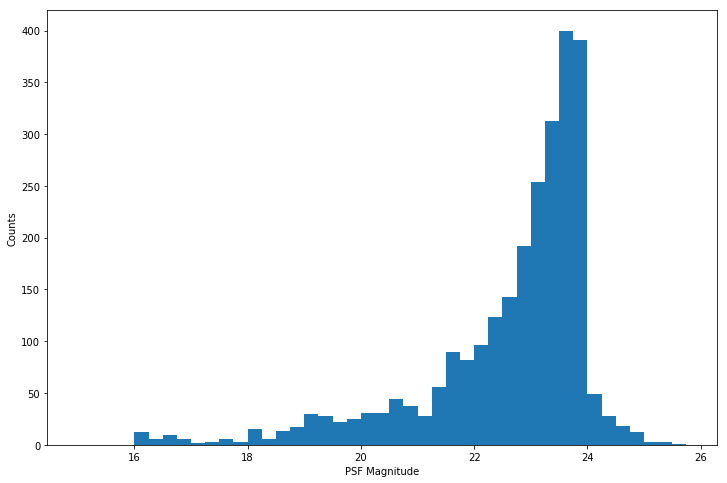

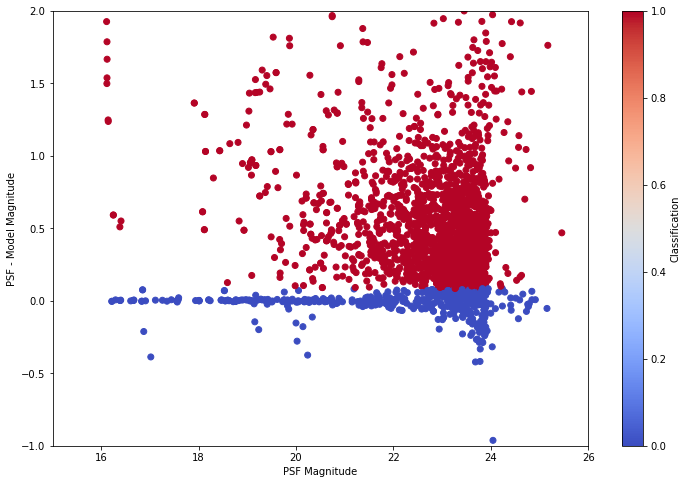

In [22]:
# This is just a demonstration of the slot functionality
np.testing.assert_equal(my_calib.getMagnitude(my_src['base_PsfFlux_flux']),
                        my_calib.getMagnitude(my_src.getPsfFlux()))

psf_mag = my_calib.getMagnitude(my_src.getPsfFlux())
#psf_mag = np.where(np.isfinite(psf_mag), psf_mag, 9999.) # Don't set sentinel values!

cm_mag = my_calib.getMagnitude(my_src.getModelFlux())
cm_mag = np.where(np.isfinite(cm_mag), cm_mag, 9999.) # Don't set sentinel values

# If you have nan or inf values in your array, use the range argument to avoid searching for min and max
plt.figure()
#plt.yscale('log', nonposy='clip')
plt.hist(psf_mag, bins=np.arange(15., 26., 0.25), range=(15., 26.))
#plt.hist(np.nan_to_num(psf_mag), bins=np.arange(15., 26., 0.25)) # Alertnative
plt.xlabel('PSF Magnitude')
plt.ylabel('Counts')

plt.figure()
plt.scatter(psf_mag, psf_mag - cm_mag, c=my_src['base_ClassificationExtendedness_value'], cmap='coolwarm')
plt.colorbar().set_label('Classification')
plt.xlim(15., 26.)
plt.ylim(-1., 2.)
plt.xlabel('PSF Magnitude')
plt.ylabel('PSF - Model Magnitude')

Now select a source based on it's properties, e.g., pick a bright star

In [23]:
# Pick a bright star candidates
#mask = ~np.isfinite(psf_mag) | (my_src['base_ClassificationExtendedness_value'] == 1)
#index = np.argmin(np.ma.masked_array(psf_mag, mask))

# Pick a bright star that was using to calibrate photometry
selection = my_src['calib_photometry_used']
index = np.argmin(np.ma.masked_array(psf_mag, ~selection))

print(psf_mag[index])
print(index)

ra_target, dec_target = my_src['coord_ra'][index], my_src['coord_dec'][index] # Radians
#print(dir(afwCoord))
#print(dir(afwGeom))
#print(help(afwGeom.Point2D))
#coord = afwCoord.Coord(ra_target * afwGeom.degrees, dec_target * afwGeom.degrees)
#coord = afwGeom.Point2D(ra_target * afwGeom.degrees, dec_target * afwGeom.degrees)
radec = afwGeom.SpherePoint(ra_target, dec_target, afwGeom.radians) # Is this really the preferred way to do this?

#xy = afwGeom.PointI(my_wcs.skyToPixel(radec)) # This converts to integer
#xy = afwGeom.Point2D(my_wcs.skyToPixel(radec))
xy = my_wcs.skyToPixel(radec)
print(my_src['base_SdssCentroid_x'][index], my_src['base_SdssCentroid_y'][index])
print(xy.getX(), xy.getY())
#print(xy)
#dir(my_wcs)
#xy = my_wcs.skyToPixel(radec)

print(my_wcs.skyToPixel(radec).getX())
print(my_src.getX()[index])

# Equivalence check
assert my_src.getX()[index] == my_src['base_SdssCentroid_x'][index]

16.293406437431383
498
1047.7129726625076 1078.3251861072881
1047.8625961761172 1078.4319767146708
1047.8625961761172
1047.7129726625076


In [24]:
# Trying to isolate some behavior here that I don't understand
ra_target, dec_target = my_src['coord_ra'][index], my_src['coord_dec'][index] # Radians
radec = afwGeom.SpherePoint(ra_target, dec_target, afwGeom.radians)
xy = my_wcs.skyToPixel(radec)
print(my_wcs.skyToPixel(radec).getX())
print(my_src.getX()[index])

1047.8625961761172
1047.7129726625076


### Challenge to the reader:
* Use callback with bokeh to interactively select a source

In [25]:
# Probably this cell should go away
#my_calexp = butler.get('calexp', dataId={'visit': 234})
#subset = butler.subset('md')
#subset = butler.subset('wcs')
#subset.cache
#my_wcs = butler.get('wcs', dataId={'visit': 234})

In [26]:
cutoutSize = afwGeom.ExtentI(100, 100)
#my_wcs.skyToPixel(coord)
xy = afwGeom.PointI(my_wcs.skyToPixel(radec))
bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)
#print(bbox)
#print(dir(my_calexp))
#print(help(butler.get))
#my_calexp.getBBox()

# Full frame image
image = butler.get('calexp', immediate=True, dataId=dataid) #.getMaskedImage()

# Postage stamp image only
cutout_image = butler.get('calexp_sub', bbox=bbox, immediate=True, dataId=dataid).getMaskedImage()

In [27]:
#import lsst.afw.display as afwDisplay
#print(dir(afwDisplay))

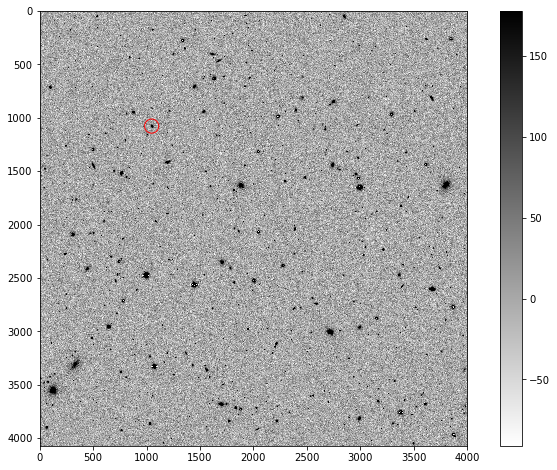

In [28]:
vmin, vmax = zscale.get_limits(image.image.array)
plt.imshow(image.image.array, vmin=vmin, vmax=vmax, cmap='binary')
plt.colorbar()
#dir(xy)
plt.scatter(xy.getX(), xy.getY(), color='none', edgecolor='red', s=200)
#my_calexp.image.array

(100, 100)


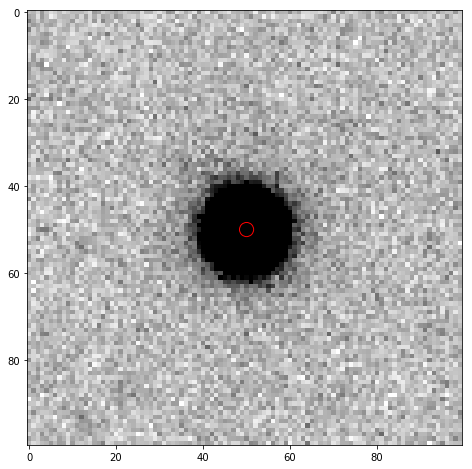

In [29]:
# Demonstration of equivalency
my_calexp_cutout = my_calexp.Factory(my_calexp, bbox, afwImage.LOCAL)
assert np.all(my_calexp_cutout.image.array == cutout_image.image.array)

print(cutout_image.getDimensions())
vmin, vmax = zscale.get_limits(cutout_image.image.array)
plt.imshow(cutout_image.image.array, vmin=vmin, vmax=vmax, cmap='binary')

# Does the cutout_image have a wcs? It does not appear to...
plt.scatter(xy.getX() - cutout_image.getX0(), xy.getY() - cutout_image.getY0(), c='none', edgecolor='red', s=200)

### Challenge to the reader:
* Can you plot the image with projection (including rotation) for equatorial coordinates with RA and Dec labeled?